# Analyse de données Budget et Finances : données pour les paniers ERRD

## Paramétrage

In [1]:
import os

import pandas as pd
CHEMIN_DOSSIER_DONNÉES = '../../../../données/DIAMANT'
DATE_FICHIER = '2022_09_01'
encoding = 'utf-8'


In [2]:
ann_per_errd_eprd = pd.read_csv(
    os.path.join(CHEMIN_DOSSIER_DONNÉES, 'ANN_PER_ERRD_EPRD_' + DATE_FICHIER + '.CSV'),
    delimiter=";",
    encoding=encoding,
    dtype='str'
)

## Doublons

### On s'attend à avoir une seule valeur par (Finess, Année, Id Dépôt)

In [3]:
ann_per_errd_eprd.head()

,Finess EJ,Finess,Année,Id Dépôt
0,480782259,480001130,2019,143783
1,130001753,130008568,2020,203489
2,440002426,440003648,2018,126667
3,370000440,370011298,2018,117146
4,060002813,060799491,2020,204473


In [4]:
ann_per_errd_eprd.duplicated(subset=["Finess", "Année", "Id Dépôt"]).sum()

0

On a bien unicité

### A-t-on un seul numéro de dépôt pour un FINESS et une année ?

In [5]:
a_plus_d_une_donnée_par_finess_par_année = (ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique() > 1)

In [6]:
a_plus_d_une_donnée_par_finess_par_année.sum() / ann_per_errd_eprd.groupby(['Finess', 'Année']).ngroups

Id Dépôt    0.929997
dtype: float64

Non : la plupart des établissements ont plusieurs numéros de dépôt pour une même année

<AxesSubplot:title={'center':'Répartition du nombre de dépôts pour un même Finess et année'}, ylabel='Frequency'>

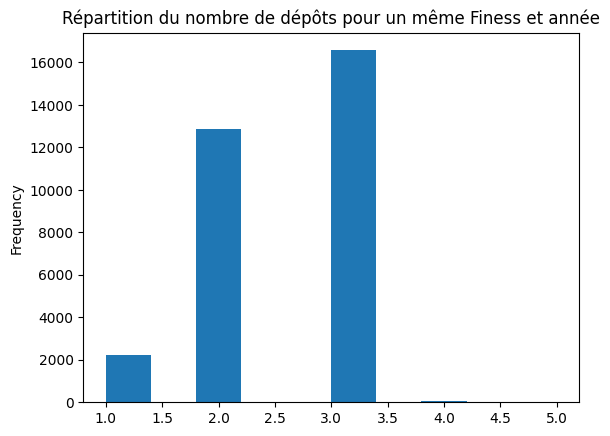

In [7]:
ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique().plot(
    kind= 'hist',
    title="Répartition du nombre de dépôts pour un même Finess et année",
    legend=False,
)

In [8]:
ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(['Finess', 'Année']).nunique().value_counts().sort_index()

Id Dépôt
1            2221
2           12864
3           16571
4              59
5              12
dtype: int64

La plupart des Finess font l'objet de 2-3 dépots / an

<AxesSubplot:title={'center':'répartition des Finess par année'}, xlabel='Année'>

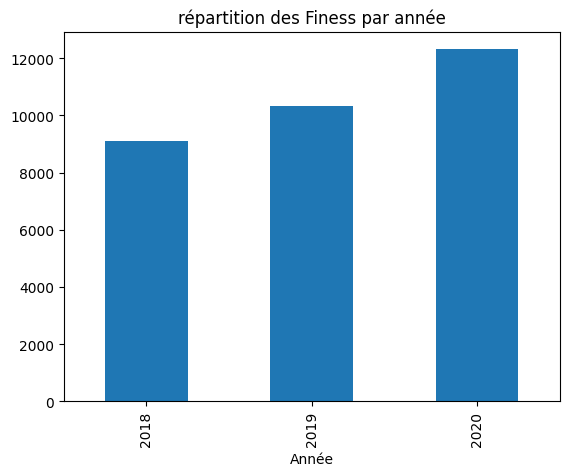

In [9]:
ann_per_errd_eprd.groupby('Année')['Finess'].nunique().plot(kind="bar", title="répartition des Finess par année")

De plus en plus d'établissements sont concernés par les paniers ERRD : on voit donc de plus en plus de numéros FINESS apparaître par année

<AxesSubplot:title={'center':'répartition des numéros de dépôt par année'}, xlabel='Année'>

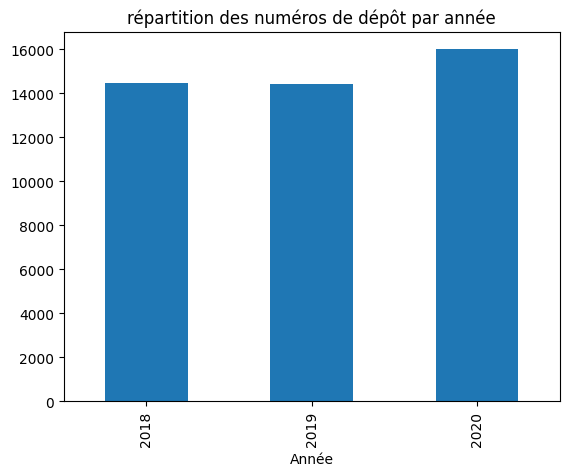

In [10]:
ann_per_errd_eprd.groupby('Année')['Id Dépôt'].nunique().plot(kind="bar", title="répartition des numéros de dépôt par année")

Le nombre de dépôts est plus stable, mais augmente en 2020

Le nombre de FINESS renseignés augmente plus que le nombre de dépôts.

## A-t-on des groupements stables ?

Un Id Dépôt correspond à une mise à jour d'un groupement d'ET. Est-ce que ces groupements restent stables, auquel cas on peut facilement dédoublonner nos données ?

In [11]:
groups = ann_per_errd_eprd[['Finess', 'Année', "Id Dépôt"]].groupby(["Id Dépôt", "Année"])['Finess'].apply(set)

In [12]:
unique_groups = groups.sort_index(ascending=False).drop_duplicates()

In [13]:
intersecting_groups = []
for group1 in unique_groups.values:
    for group2 in unique_groups.values:
        if (group1 != group2) and group1.intersection(group2):
            intersecting_groups.append((group1, group2))

In [14]:
len(intersecting_groups) / 2

1649.0

On voit que, dans une même année, les groupes d'ET qui sont déposés ensemble évoluent. Lequel fait foi ?
Réponse de Nicolas : pour chaque année, on prend le numéro de dépôt le plus élevé renseigné pour un FINESS. Questions persistantes : j'ai l'impression que parfois les dépôts ont des données partielles, complétées par des dépôts suivants

## Le taux de vétusté et de CAF par FINESS

### Les données des dépôts par paniers ERRD

In [15]:
ann_errd_ej = pd.read_csv(
    os.path.join(CHEMIN_DOSSIER_DONNÉES, 'ANN_ERRD_EJ_' + DATE_FICHIER + '.CSV'),
    delimiter=";",
    encoding=encoding,
    dtype={"Id Dépôt": str},
)


In [16]:
ann_errd_ej.head()


,Finess EJ,Année,Id Dépôt,Taux de CAF ERRD,Taux vétusté Autres immo ERRD,Taux vétusté Construction ERRD,Taux vétusté installations tech mat outil ERRD,Fonds de roulement net global ERRD
0,NaN,2020,NaN,0.071600,0.735704,0.455560,0.755128,7.426844e+09
1,NaN,2020,NaN,0.075539,0.754844,0.445467,0.754656,8.039525e+08
2,NaN,2020,NaN,0.082984,0.768304,0.368280,0.797400,9.795877e+06
3,080000375,2020,177374,0.135487,0.342110,0.388451,0.292006,2.206969e+06
4,080000433,2020,216495,-0.012266,0.881638,0.809068,0.883915,1.057218e+06


Valeurs manquantes par colonne identifiante :

In [17]:
ann_errd_ej[["Finess EJ", "Année", "Id Dépôt"]].isna().sum() / ann_errd_ej.shape[0]


Finess EJ    0.02956
Année        0.00000
Id Dépôt     0.02956
dtype: float64

On a près de 3% des données des dépôts qu'on ne peut pas lier à des établissements, parce que leur numéro de dépôt et leur numéro FINESS EJ sont manquants.

❓ **Question à DIAMANT** : pourquoi a-t-on autant de dépôts "orphelins" ?

Pour la suite, nous alons simplement ignorer les dépôts non-identifiables

### Données des paniers ERRD par FINESS

In [18]:
ann_errd_ej = ann_errd_ej.dropna(subset=["Id Dépôt"]).astype(dtype={"Id Dépôt" : str})

In [19]:
ann_errd_ej_par_finess = ann_per_errd_eprd.astype(dtype={"Id Dépôt" : str}).merge(ann_errd_ej, on="Id Dépôt", how="right")

ann_errd_ej_par_finess.head()

On vérifie la cohérence des données : a-t-on bien les mêmes années et FINESS EJ pour les mêmes Id Dépôt dans les deux fichiers ?

In [20]:
(ann_errd_ej_par_finess["Année_x"].astype(int) != ann_errd_ej_par_finess["Année_y"].astype(int)).sum()

0

In [21]:
(ann_errd_ej_par_finess["Finess EJ_x"].astype(str) != ann_errd_ej_par_finess["Finess EJ_y"].astype(str)).sum()


0

✅ Il n'y a pas d'incohérence sur les Années et FINESS EJ entre les deux fichiers

#### A-t-on beaucoup de dépôts pour un seul couple (Année, FINESS) ?

<AxesSubplot:>

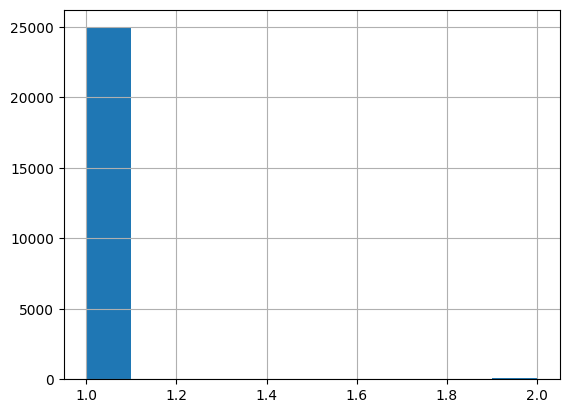

In [22]:
ann_errd_ej_par_finess.groupby(["Finess", "Année_x"])['Id Dépôt'].nunique().hist()


In [23]:
ann_errd_ej_par_finess.groupby(["Finess", "Année_x"])['Id Dépôt'].nunique().value_counts()


1    24970
2       64
Name: Id Dépôt, dtype: int64

La grande majorité n'a qu'un seul dépôt par an, quelques rares cas en ont deux. Regardons de plus près à quoi ressemblent les données des établissements ayant deux dépôts pour une même année

#### Comment traiter les valeurs manquantes ?

Proposition :
- Prendre les dépôts passés pour remplir les valeurs manquantes dans le dernier dépôt
- Ne garder que le dernier dépôt

In [24]:
dépôts_pour_un_même_établissement_et_année = ann_errd_ej_par_finess[ann_errd_ej_par_finess.duplicated(subset=["Finess", "Année_x"], keep=False)].sort_values(["Finess", "Année_x"])


In [25]:
dépôts_pour_un_même_établissement_et_année_avec_données_manquantes_remplies = dépôts_pour_un_même_établissement_et_année.groupby(["Finess", "Année_x"]).ffill()

In [26]:
dépôts_pour_un_même_établissement_et_année_avec_données_manquantes_remplies[["Finess", "Année_x"]] = dépôts_pour_un_même_établissement_et_année[["Finess", "Année_x"]]

In [27]:
dépôts_pour_un_même_établissement_et_année_avec_données_manquantes_remplies.drop_duplicates(subset=["Finess", "Année_x"], keep='last')


,Finess EJ_x,Id Dépôt,Finess EJ_y,Année_y,Taux de CAF ERRD,Taux vétusté Autres immo ERRD,Taux vétusté Construction ERRD,Taux vétusté installations tech mat outil ERRD,Fonds de roulement net global ERRD,Finess,Année_x
6656,020000022,211374,020000022,2020,0.039218,NaN,NaN,NaN,NaN,020004719,2020
19760,030780100,133864,030780100,2018,-0.034734,NaN,NaN,NaN,NaN,030005649,2018
19762,030780100,133864,030780100,2018,-0.034734,NaN,NaN,NaN,NaN,030783344,2018
19761,030780100,133864,030780100,2018,-0.034734,NaN,NaN,NaN,NaN,030786032,2018
9475,060791795,197877,060791795,2020,0.059219,0.641266,NaN,1.000000,148228.00,060790920,2020
...,...,...,...,...,...,...,...,...,...,...,...
11622,870000890,167438,870000890,2019,0.027942,0.924340,0.560261,0.969807,962896.91,870000197,2019
11623,870000890,167438,870000890,2019,0.027942,0.924340,0.560261,0.969807,962896.91,870016433,2019
18746,880000385,100768,880000385,2018,0.076203,0.797708,0.632916,0.679916,678605.30,880781174,2018
10609,880000385,153182,880000385,2019,0.090248,NaN,NaN,NaN,749427.63,880781174,2019
